In [1]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms

from collections import defaultdict
from sklearn.metrics import confusion_matrix

In [2]:
train_path = os.path.join("data", "train")
test_path = os.path.join("data", "test")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale(),
    transforms.Resize((64, 64)),
    transforms.Normalize((0.5,), (0.5,)),
])

train_dataset = datasets.ImageFolder(train_path, transform=transform)
test_dataset = datasets.ImageFolder(test_path, transform=transform)

In [3]:
classes = train_dataset.classes
num_classes = len(classes)

print("\nClasses:")
for i, label_name in enumerate(classes):
    print(f"   {i} - {classes[i].replace('_', ' ').capitalize()}")


Classes:
   0 - Chris evans
   1 - Chris hemsworth
   2 - Mark ruffalo
   3 - Robert downey jr
   4 - Scarlett johansson


In [4]:
train_size = len(train_dataset)
test_size = len(test_dataset)

In [5]:
X_train = torch.zeros((train_size, 64*64), dtype=torch.float32)

X_test = torch.zeros((test_size, 64*64), dtype=torch.float32)
y_test = torch.zeros((test_size), dtype=torch.long)

for i, (X, _) in enumerate(train_dataset):
    X_train[i] = X.view(1, -1)

for i, (X, y) in enumerate(test_dataset):
    X_test[i] = X.view(1, -1)
    y_test[i] = y

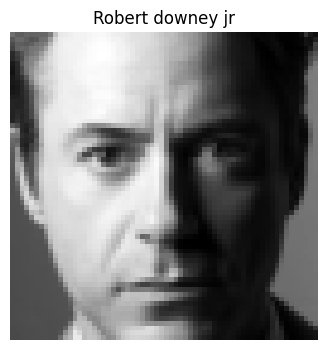

In [6]:
plt.figure(figsize=(4, 4))
plt.imshow(X_test[46].reshape(64, 64), cmap="gray")
plt.title(classes[y_test[46]].replace('_', ' ').capitalize(), fontsize=12)
plt.axis("off")
plt.show()

In [7]:
class SOM:
    def __init__(
        self,
        m:     int,
        n:     int,
        dim:   int,
        n_it:  int,
        lr:    float,
        sigma: float
    ) -> None:
        """
        m x n: int - Grid size.
        dim:   int - Input vector dimension.
        n_it:  int - Number of training step.
        lr:    float - Initial Learning Rate.
        sigma: float - Initial neighborhood radius.
        """
        self.m = m
        self.n = n
        self.dim = dim

        self.num_iterations = n_it
        self.lr = lr
        self.sigma = sigma if sigma else max(m, n) / 2

        self.weights = (torch.rand((m * n, dim), dtype=torch.float32) - 0.5) * 2
        self.locations = torch.tensor(
            np.array([[i, j] for i in range(m) for j in range(n)], dtype=np.float32)
        )
    
    def fit(self, data: torch.Tensor) -> None:
        """
        data: torch.Tensor - Input data for training SOM model.
        """
        initial_lr = self.lr
        initial_sigma = self.sigma
        for step in range(self.num_iterations):
            # self.lr = self.lr * (1 - step / self.num_iterations)
            # self.sigma = self.sigma * (1 - step / self.num_iterations)

            self.lr = initial_lr * np.exp(-step / (self.num_iterations / 2))
            self.sigma = initial_sigma * np.exp(-step / self.num_iterations)

            idx = np.random.randint(0, len(data))
            input_vec = data[idx]

            dists = torch.cdist(input_vec.unsqueeze(0), self.weights).squeeze()

            bmu_index = torch.argmin(dists)
            bmu_location = self.locations[bmu_index]

            grid_dists = torch.cdist(bmu_location.unsqueeze(0), self.locations).squeeze()

            neighborhood = torch.exp(-(grid_dists ** 2) / (2 * self.sigma ** 2))
            # neighborhood = (1 / (self.sigma * np.sqrt(2 * np.pi))) * torch.exp(-(grid_dists ** 2) / (2 * self.sigma ** 2))

            delta = self.lr * neighborhood.unsqueeze(1) * (input_vec - self.weights)
            self.weights += delta
    
    def map_input(self, input_vec: torch.Tensor):
        """
        """
        dists = torch.cdist(input_vec.unsqueeze(0), self.weights).squeeze()
        bmu_index = torch.argmin(dists)
        return self.locations[bmu_index]

    def get_weights_2d(self):
        """
        """
        return self.weights.view(self.m, self.n, self.dim)

In [8]:
som_model = SOM(m=100, n=100, dim=64*64, n_it=3000, lr=1.0, sigma=5.0)
som_model.fit(X_train)

In [9]:
label_map = np.full((som_model.m, som_model.n), -1)
count_map = {}

for i in range(len(X_test)):
    input_vector = X_test[i]
    label = y_test[i]
    bmu_index = som_model.map_input(input_vector)
    bmu_tuple = tuple(int(v) for v in bmu_index.tolist())

    if bmu_tuple not in count_map:
        count_map[bmu_tuple] = []
    count_map[bmu_tuple].append(label)

for key in count_map:
    values = count_map[key]
    label_map[key] = max(set(values), key=values.count)

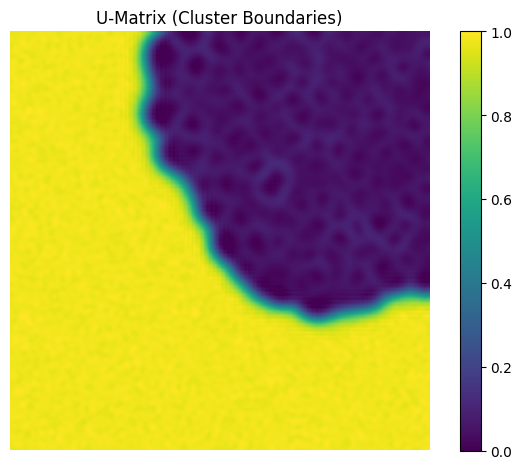

In [10]:
weights = som_model.get_weights_2d().detach().numpy()
umatrix = np.zeros((som_model.m, som_model.n))

for i in range(som_model.m):
    for j in range(som_model.n):
        neighbors = []
        if i > 0: neighbors.append(weights[i - 1][j])
        if i < som_model.m - 1: neighbors.append(weights[i + 1][j])
        if j > 0: neighbors.append(weights[i][j - 1])
        if j < som_model.n - 1: neighbors.append(weights[i][j + 1])

        dist = np.mean([np.linalg.norm(weights[i][j] - n) for n in neighbors])
        umatrix[i][j] = dist

umatrix = (umatrix - umatrix.min()) / (umatrix.max() - umatrix.min())

plt.imshow(umatrix, interpolation="sinc", cmap="viridis")
plt.title("U-Matrix (Cluster Boundaries)")
plt.axis("off")
plt.colorbar()
plt.tight_layout()
plt.show()

In [11]:
# For each x gets your bmu and your label
# hashmap should:
# > tuple(bmu index): list(labels) -- Ex: (60, 0): [0, 4]
label_map = defaultdict(list)
for i in range(len(X_test)):
    input_vector = X_test[i]
    label = y_test[i].item()
    bmu_index = som_model.map_input(input_vector).tolist()
    bmu_tuple = tuple(int(v) for v in bmu_index)
    label_map[bmu_tuple].append(label)

In [12]:
# Mapping each neurons position and gets the neuron label
neuron_labels = {position: max(set(labels), key=labels.count) for position, labels in label_map.items()}

In [13]:
def classify(som: SOM, input_vector: torch.Tensor, neuron_labels: dict):
    input_vector = input_vector.view(1, -1)
    bmu_index = som.map_input(input_vector).tolist()
    bmu_position = tuple([int(v) for v in bmu_index])
    return neuron_labels.get(bmu_position)

In [14]:
x = X_test[10]
pred = classify(som_model, x, neuron_labels)

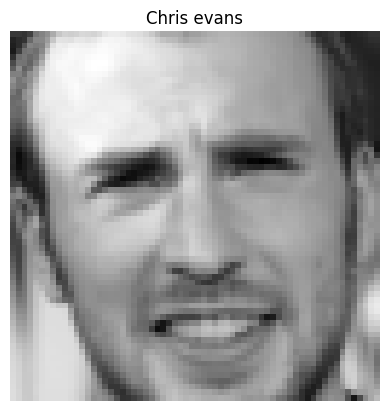

In [15]:
plt.imshow(x.view(64, 64), cmap="gray")
plt.axis("off")
plt.title(classes[pred].replace('_', ' ').capitalize(), fontsize=12)
plt.show()

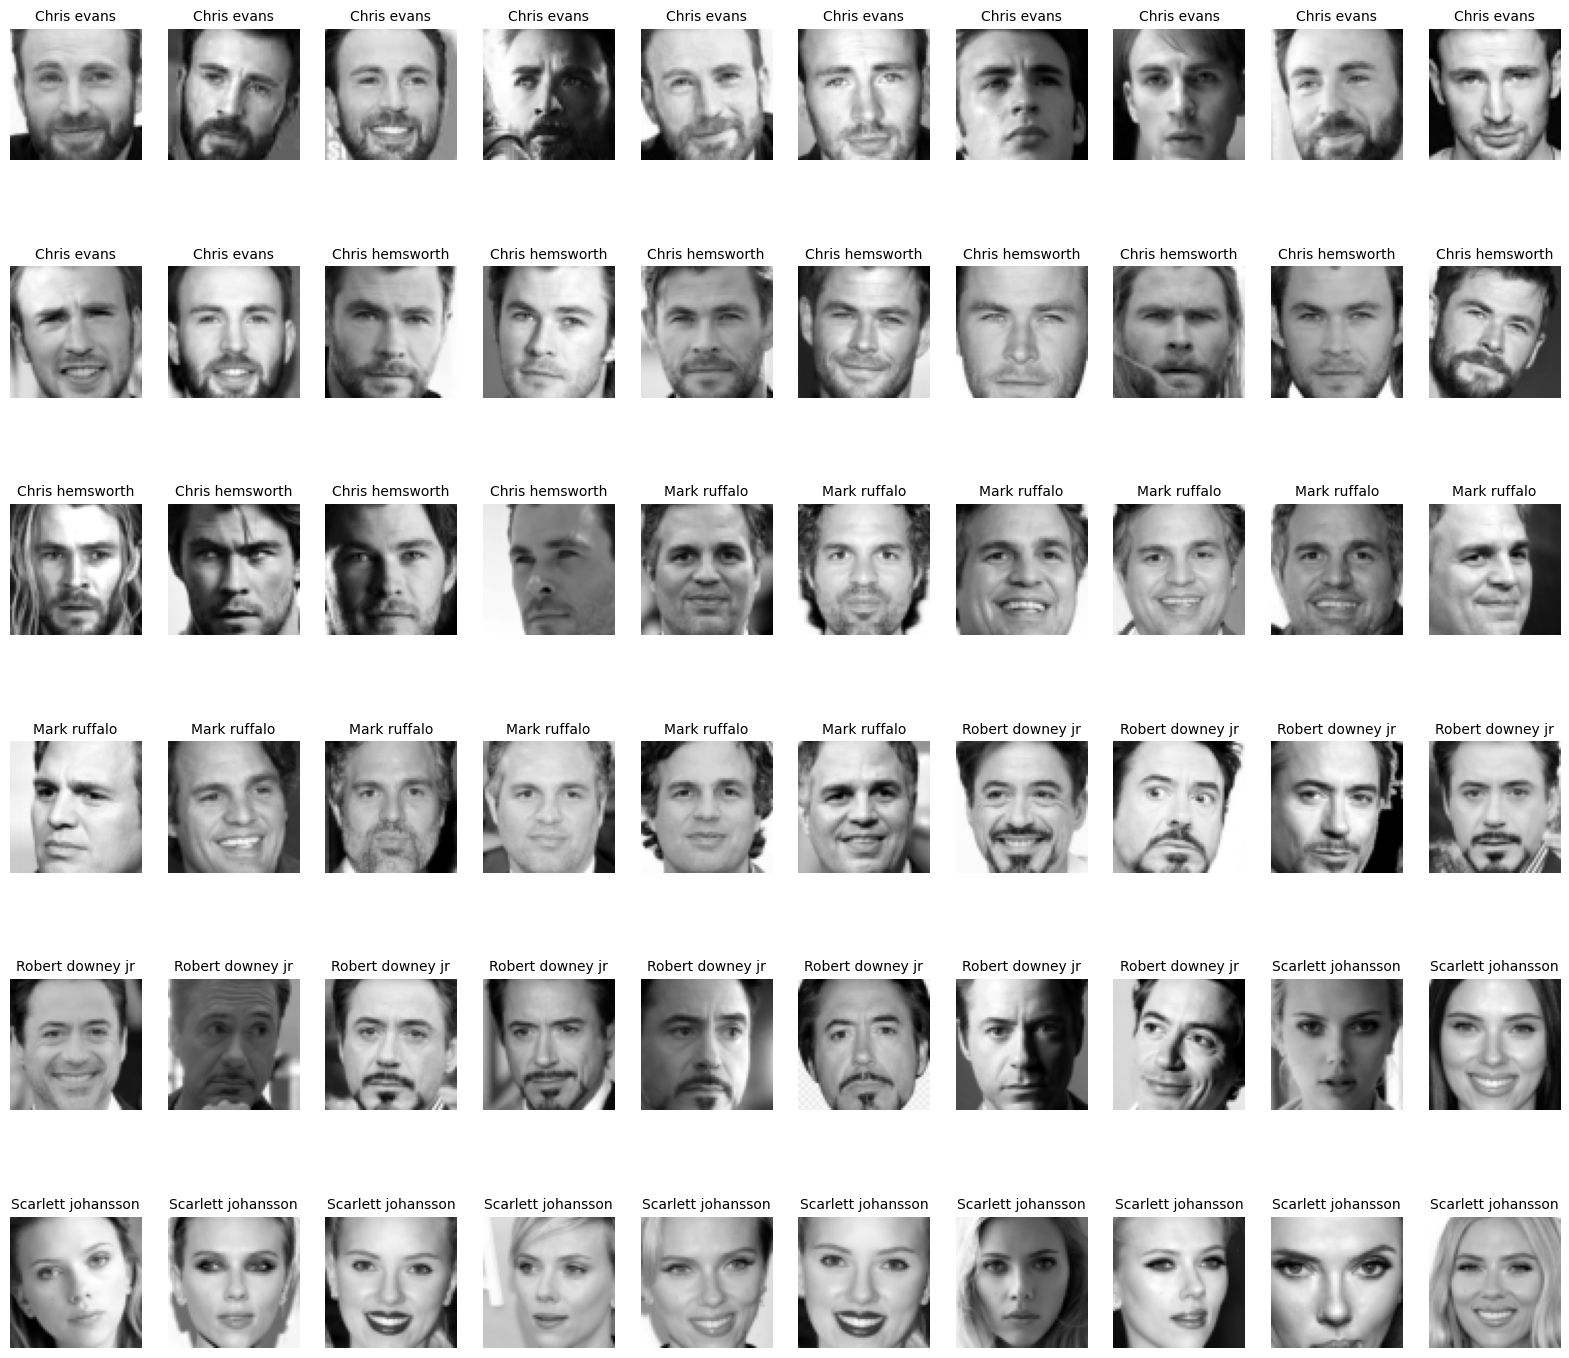

In [16]:
preds = []

fig = plt.figure(figsize=(20, 18))
for i, X in enumerate(X_test):
    input_vector = X.view(1, -1)
    pred = classify(som_model, input_vector, neuron_labels)
    preds.append(pred)
    fig.add_subplot(6, 10, i+1)
    plt.imshow(X.reshape(64, 64), cmap="gray")
    plt.title(classes[pred].replace('_', ' ').capitalize(), fontsize=10)
    plt.axis("off")
plt.show()

preds = np.array(preds, dtype=np.long)

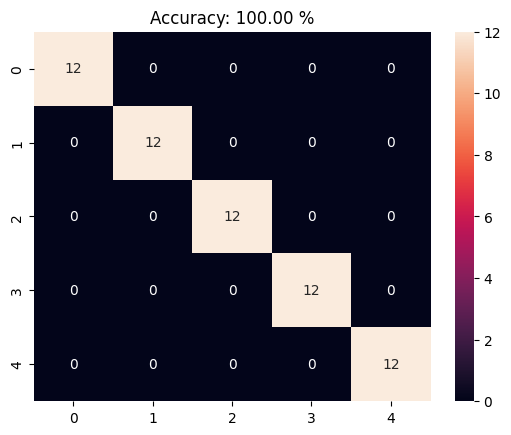

In [17]:
cm = confusion_matrix(y_test, preds)
sns.heatmap(cm, annot=True, fmt='g')
plt.title(f"Accuracy: {( np.sum((preds == y_test.numpy()) / len(X_test))) * 100:.2f} %")
plt.show()